In [8]:
from utils_csa import save_obj, load_obj

import pandas.io.sql as psql
import pandas as pd
import numpy as np

from pytz import timezone
from datetime import datetime, timedelta, date

ORDER_BUY  = 'buy'
ORDER_SELL = 'sell'  

# load rf classifier already fitted
clf = load_obj('clf_xgbc_2018_11_19')
X_test = load_obj('clf_xgbc_2018_11_19_X_test')
y_test = load_obj('clf_xgbc_2018_11_19_y_test')
close_price = load_obj('clf_xgbc_2018_11_19_X_test_close_price')
target = load_obj('clf_xgbc_2018_11_19_target')

In [26]:
class Alg_order:
    def __init__(self, id_order, base_asset, quote_asset, side, quantity_base, quantity_quote, price, fees, fees_quote_asset):
        self.id_order = id_order
        self.base_asset = base_asset
        self.quote_asset = quote_asset
        self.side = side
        self.quantity_base = quantity_base
        self.quantity_quote = quantity_quote
        self.price = price
        self.fees = fees
        self.fees_quote_asset = fees_quote_asset

# Faire une classe mère Trading_api avec héritage
#class Trading_api_fake(Trading_api):   
class Trading_api_fake:    
    def __init__(self):
        self.positions = {}
        self.fees = 0
        self.nb_periods_price_to_buy = 1 # approx because actions will have delay
        self.orders = {}
        
    def __get_price(self, base_asset, quote_asset, key):
        return self.close_prices[base_asset + quote_asset][key + self.nb_periods_price_to_buy]
    
    def init_from_backtesting_strategy(self, init_positions, fees, close_prices):
        self.positions = init_positions
        self.fees = fees
        self.close_prices = close_prices
        
    def get_available_amount_crypto(self, symbol):
        if symbol in self.positions:
            return self.positions[symbol]
        else:
            return 0.0
        
    def __get_from_to(self, base_asset, quote_asset, side):
        if side == ORDER_BUY:
            from_crypto = quote_asset
            to_crypto = base_asset
        else:
            from_crypto = base_asset
            to_crypto = quote_asset
        return from_crypto, to_crypto
    
    # market for the moment => to be scheduled with like market minus 0.5% 
    def create_order(self, base_asset, quote_asset, side, quantity_from, key): # ex: USDT, ETH, 1000, BUY        
        # if cryptos exists
        if base_asset in self.positions and quote_asset in self.positions:
            from_crypto, to_crypto = self.__get_from_to(base_asset, quote_asset, side)
            
            # calcul fees
            fees = quantity_from * self.fees
            fees_quote_asset = fees
            
            # get price
            price_init = self.__get_price(base_asset, quote_asset, key)
            price = price_init
            
            # switch when Sell order
            if side == ORDER_SELL:
                fees_quote_asset = fees * price
                price = 1 / price
                
            
            # do exchange between cryptos
            self.positions[from_crypto] = self.positions[from_crypto] - quantity_from
            quantity_to = (quantity_from - fees) / price       
            self.positions[to_crypto] = self.positions[to_crypto] + quantity_to
            base_asset_quantity, quote_asset_quantity = self.__get_from_to(quantity_from, quantity_to, side)
            
            # create order already executed (for simulation needs)
            
            order = Alg_order(len(self.orders), base_asset, quote_asset, side, base_asset_quantity, quote_asset_quantity, price_init, fees, fees_quote_asset)
            self.orders[order.id_order] = order            
            return order.id_order
        else:
            raise ValueError('ERROR (create_order):  cryptos doesn''t exists - ' + from_crypto + '/' + to_crypto)
    
    def get_order(self, id_order):
        return self.orders[id_order]
    
    def get_orders(self):
        return self.orders

class Trading_module:
    signals_x_buy = []
    signals_y_buy = []
    
    x_sell = []
    y_sell = []
    
    amount_x = []
    amount_y = []
    
    def __init__(self, trading_api, param_bet_size, param_min_bet_size, base_asset, quote_asset):
        self.trading_api = trading_api
        self.base_asset = base_asset
        self.quote_asset = quote_asset
        
        self.nb_periods_to_hold_position = 24 #1d => TODO : sell must be done if pct_change model touched / check close price
        self.param_bet_size = param_bet_size
        self.param_min_bet_size = param_min_bet_size
        
    def __can_buy(self):   
        return self.trading_api.get_available_amount_crypto(self.quote_asset) >= self.param_min_bet_size
    
    # Attention From crypto / to crypto => Pas logique, on parle de trading pair !
    # Change bet size regarding proba ?
    def __do_buy(self, key):       
        cash_amount_to_use = self.trading_api.get_available_amount_crypto(self.quote_asset) * self.param_bet_size
        id_order = self.trading_api.create_order(self.base_asset, self.quote_asset, ORDER_BUY, cash_amount_to_use, key)
        order = self.trading_api.get_order(id_order)
        
        # TODO : System that ensure that order is executed, may modify order, etc.
        
        # trace
        print('[BUY] ORDER PLACED (' + str(key) + '): ' + str(order.quantity_base) + ' tokens for '
               + str(order.quantity_quote) + '$ (close_price = ' + str(round(order.price, 2))
              + '$ / fees = ' + str(round(order.fees_quote_asset, 2)) + ')')
        
        self.signals_x_buy.append(key)
        self.signals_y_buy.append(order.price)
        
    # if no signal for more than nb period to keep a position
    # TODO, modify to take into account multiple crypto positions
    def __should_sell(self, current_key, last_signal_key):        
        if (current_key - last_signal_key >= self.nb_periods_to_hold_position) and \
            (self.trading_api.get_available_amount_crypto(self.base_asset) > 0):
            return True
        return False

    # no signal since last n periods (nb periods position should be holded) => sell
    def __do_sell(self, key):
        crypto_quantity = self.trading_api.get_available_amount_crypto(self.base_asset)
        if crypto_quantity > 0:
            self.__sell(key, self.base_asset, self.quote_asset, crypto_quantity)
    
    # TODO : Manage multiple cryptos
    def do_sell_all(self, key):
        self.__do_sell(key) 
        
    def __sell(self, key, from_crypto, to_crypto, crypto_amount):
        id_order = self.trading_api.create_order(self.base_asset, self.quote_asset, ORDER_SELL, crypto_amount, key)
        order = self.trading_api.get_order(id_order)
        
        print('[SELL] ORDER PLACED (' + str(key) + '): ' + str(order.quantity_base) + ' tokens for '
               + str(order.quantity_quote) + '$ (close_price = ' + str(round(order.price, 2)) 
              + '$ / fees = ' + str(round(order.fees_quote_asset, 2)) + ')')

        self.x_sell.append(key)
        self.y_sell.append(order.price)
        
        self.amount_x.append(key)
        self.amount_y.append(self.trading_api.get_available_amount_crypto(self.quote_asset))
    
    # check actions to be done (buy / sell) 
    def do_update(self, key, signal, last_signal_key):
        if self.__should_sell(key, last_signal_key):
            self.__do_sell(key)
        if signal and self.__can_buy():
            self.__do_buy(key)
            
    def get_available_amount_crypto(self, symbol):
        return self.trading_api.get_available_amount_crypto(symbol)
    
    def get_all_fees_paid(self):
        fees = 0
        for key, order in self.trading_api.get_orders().items():
            fees = fees + order.fees_quote_asset
        return fees
    
    def get_nb_transactions_done(self):
        return len(self.trading_api.get_orders())
    
    def get_signals(self):
        return self.signals_x_buy, self.signals_y_buy, self.x_sell, self.y_sell, self.amount_x, self.amount_y

# REmplacer from crypto - to crypto par trading pair avec side
class Backtesting_strategy:    
    def __init__(self, model, X_test, close_price, target, threshold, base_asset, quote_asset, trading_pair):
        self.param_init_amount_cash = 1000.0 # $
        self.param_fees = 0.001 # 0.1%
        self.param_bet_size = 1.00 #%
        self.param_min_bet_size = 100.0 # $
        
        self.model = model
        self.X_test = X_test
        self.close_price = close_price
        self.target = target
        self.market_price_begin = close_price[trading_pair][0]
        self.market_price_end = close_price[trading_pair][len(close_price[trading_pair]) - 1]
        
        self.__calcul_signals(threshold)
        
#         self.amount_x.append(0)
#         self.amount_y.append(self.param_init_amount_cash)
        
        # Trading API (fake one for simulation)
        init_positions = {quote_asset: self.param_init_amount_cash, base_asset: 0.0}
        trading_api = Trading_api_fake()
        trading_api.init_from_backtesting_strategy(init_positions, self.param_fees, self.close_price)
        
        # Trading module
        self.trading_module = Trading_module(trading_api, self.param_bet_size, self.param_min_bet_size, base_asset, quote_asset)
    
    def __calcul_signals(self, threshold):        
        predicted_proba = self.model.predict_proba(self.X_test)
        probs = predicted_proba[:, 1] # 0 or 1
        self.signals = (probs >= threshold)
    
    def override_signals(self, y_test):
        self.signals = y_test
        
    def get_signals(self):
        return self.trading_module.get_signals()
    
    def do_backtest(self, trace=True):
        last_signal_key = -1
        for key, signal in enumerate(self.signals):
            if signal:
                last_signal_key = key
            # not last line of dataset
            if key < (len(self.signals) - 2):
                # TODO : pass per crypto to allow multiple crypto
                self.trading_module.do_update(key, signal, last_signal_key)
            else:
                self.trading_module.do_sell_all(key)
                break
        
        # Results
        simulation_time = round(len(self.X_test) / 24)
        final_amount = round(self.trading_module.get_available_amount_crypto(quote_asset), 2)
        all_fees_paid = round(self.trading_module.get_all_fees_paid(), 2)
        pct_change_portfolio = round((final_amount - self.param_init_amount_cash) / self.param_init_amount_cash * 100, 2)
        pct_change_market = round((self.market_price_end - self.market_price_begin) / self.market_price_begin * 100, 2)
        
        if trace:
            print('\n')
            print('Simulation time: ' + str(simulation_time) + ' days')
            print('Start amount: ' + str(self.param_init_amount_cash) + '$')
            print('Final amount: ' + str(final_amount) + '$')
            print('Fees: ' + str(all_fees_paid) + '$')
            print('Pourcentage change portfolio: ' + str(pct_change_portfolio) + '%')
            print('Pourcentage change market: ' + str(pct_change_market) + '%')
        
        return simulation_time, final_amount, all_fees_paid, pct_change_portfolio, pct_change_market
    
    def show_graphs(self):
        # here to avoid problem when started in batch mode
        from matplotlib import pyplot as plt
        signals_x, signals_y, x_sell, y_sell, amount_x, amount_y = self.get_signals()

        plt.figure(figsize=(20,10))
        plt.plot(close_price)
        plt.plot(signals_x, signals_y, '^', markersize=10, color='g')
        plt.plot(x_sell, y_sell, 'v', markersize=10, color='r')
        plt.xlabel('h + n hours')
        plt.ylabel('close_price')
        plt.show()

        plt.figure(figsize=(20,10))
        plt.plot(amount_x, amount_y, color='y')
        plt.xlabel('h + n hours')
        plt.ylabel('portfolio_value')
        plt.show()

[BUY] ORDER PLACED (278): 3.7383527298581742 tokens for 1000.0$ (close_price = 267.23$ / fees = 1.0)
[SELL] ORDER PLACED (349): 3.7383527298581742 tokens for 1116.7617371926804$ (close_price = 299.03$ / fees = 1.12)
[BUY] ORDER PLACED (568): 4.109795091193869 tokens for 1116.7617371926804$ (close_price = 271.46$ / fees = 1.12)
[SELL] ORDER PLACED (634): 4.109795091193869 tokens for 1214.1743126164445$ (close_price = 295.73$ / fees = 1.22)
[BUY] ORDER PLACED (685): 4.338818637515481 tokens for 1214.1743126164445$ (close_price = 279.56$ / fees = 1.21)
[SELL] ORDER PLACED (756): 4.338818637515481 tokens for 1266.4916582779526$ (close_price = 292.19$ / fees = 1.27)
[BUY] ORDER PLACED (902): 6.665394408490542 tokens for 1266.4916582779526$ (close_price = 189.82$ / fees = 1.27)
[SELL] ORDER PLACED (948): 6.665394408490542 tokens for 1312.1691395150092$ (close_price = 197.06$ / fees = 1.31)
[BUY] ORDER PLACED (973): 7.318725757218995 tokens for 1312.1691395150092$ (close_price = 179.11$ / fee

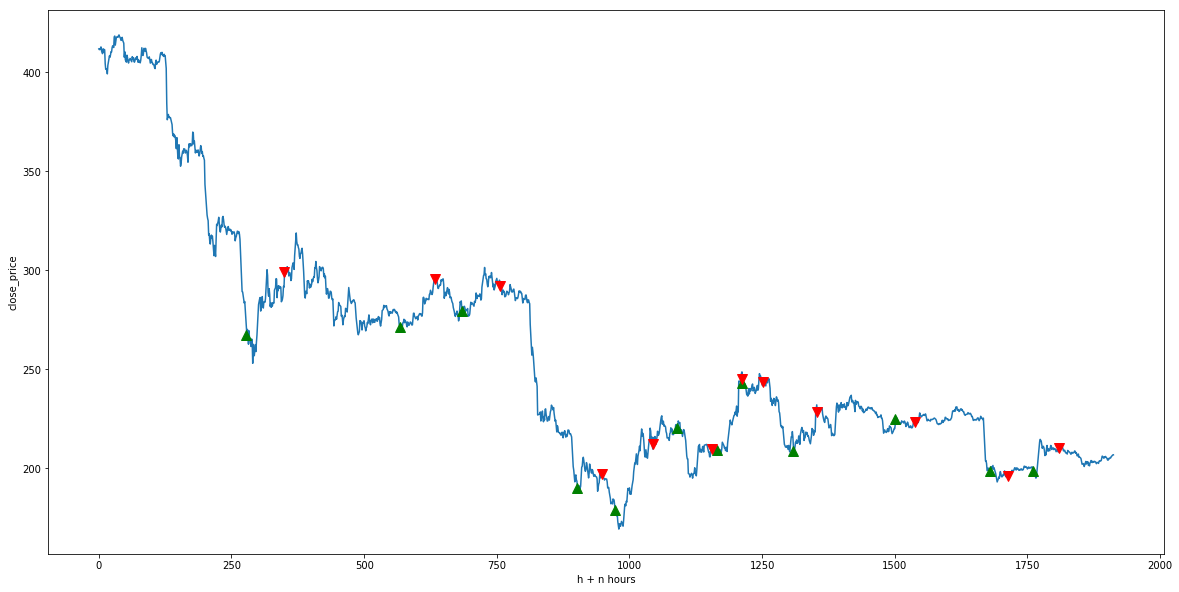

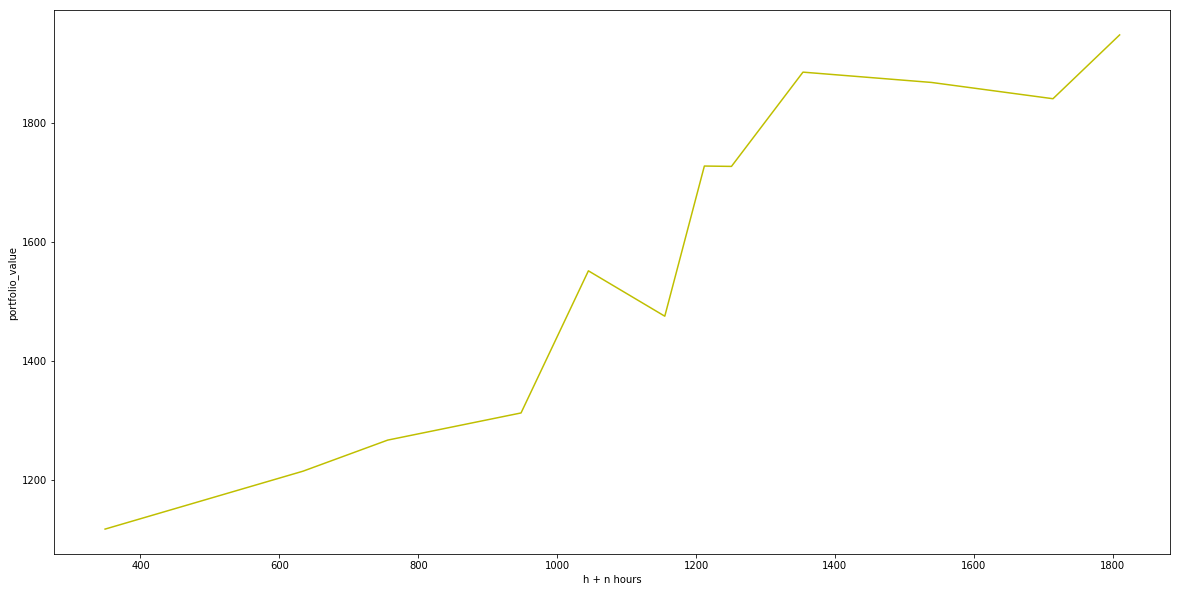

In [27]:
# base_asset = 'ETH'
# quote_asset = 'USDT'
# trading_pair = base_asset + quote_asset
# backtest = Backtesting_strategy(clf, X_test, {trading_pair: close_price}, target, 0.58, base_asset, quote_asset, trading_pair)
# #backtest.override_signals(y_test)
# backtest.do_backtest()
# backtest.show_graphs()